Fetched data from staff: 502004 records.
Fetched data from orders: 505002 records.
Orders DataFrame columns: Index(['id', 'client_name', 'event_date', 'menu_items', 'quantity',
       'order_status', 'total_cost'],
      dtype='object')
Staff DataFrame columns: Index(['id', 'staff_member', 'event_date', 'shift_start', 'shift_end',
       'assigned_event'],
      dtype='object')
Concatenated DataFrame has 1007006 rows and 13 columns.
Staff order ratio calculated successfully.
Exported staff_data to staff_data.csv
Exported orders_data to orders_data.csv
Exported merged_data to merged_data.csv


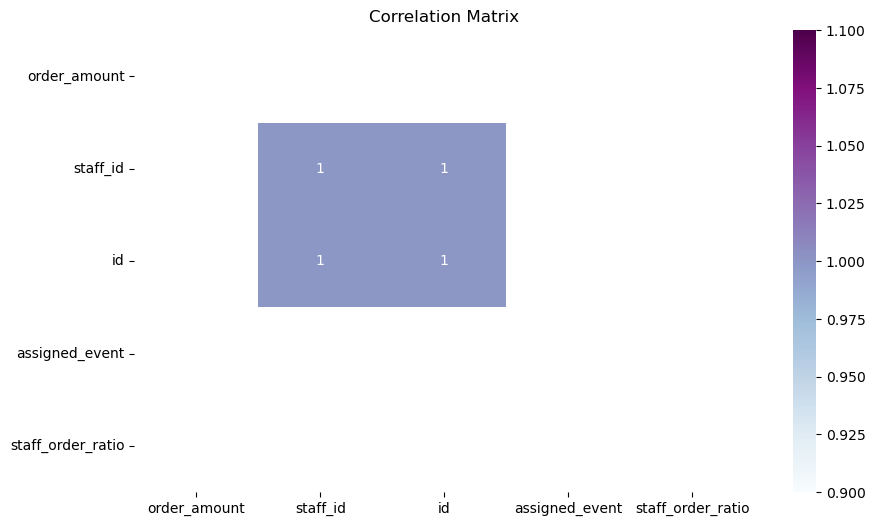

Script completed successfully.


In [3]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Authentication
USERNAME = "hugues"
PASSWORD = "K1vumbii"

BASE_URL = "http://127.0.0.1:8000/api"

def fetch_data(endpoint: str, auth=None):
    """Fetches data from the API and returns it as a DataFrame."""
    try:
        response = requests.get(f"{BASE_URL}/{endpoint}/", auth=auth)
        response.raise_for_status()
        data = response.json()
        print(f"Fetched data from {endpoint}: {len(data)} records.")
        return pd.DataFrame(data)
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data from API: {e}")
        return pd.DataFrame()

def clean_data(df: pd.DataFrame):
    """Cleans a DataFrame by filling missing values."""
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = df[column].fillna('Unknown')
        else:
            df[column] = df[column].fillna(0)
    return df

# Fetch Data
auth = (USERNAME, PASSWORD)
staff_df = fetch_data("staff", auth)
orders_df = fetch_data("orders", auth)

# Debugging: Inspect fetched data
print("Orders DataFrame columns:", orders_df.columns)
print("Staff DataFrame columns:", staff_df.columns)

# Clean data
staff_df = clean_data(staff_df)
orders_df = clean_data(orders_df)

# Ensure necessary columns exist
if "order_amount" not in orders_df.columns:
    print("Warning: 'order_amount' column not found in orders_df. Adding a placeholder column.")
    orders_df["order_amount"] = 0.0  # Placeholder

if "staff_id" not in orders_df.columns:
    print("Warning: 'staff_id' column not found in orders_df. Adding a placeholder column.")
    orders_df["staff_id"] = np.nan

# Align IDs: Ensure 'staff_id' matches 'id' in staff_df
if not staff_df.empty and "id" in staff_df.columns:
    if orders_df["staff_id"].isnull().any():
        random_staff_ids = np.random.choice(staff_df["id"], size=orders_df["staff_id"].isnull().sum(), replace=True)
        orders_df.loc[orders_df["staff_id"].isnull(), "staff_id"] = random_staff_ids
    orders_df["staff_id"] = orders_df["staff_id"].astype(int)

# Concatenate the DataFrames
concat_df = pd.concat([orders_df, staff_df], axis=0, ignore_index=True)
print(f"Concatenated DataFrame has {concat_df.shape[0]} rows and {concat_df.shape[1]} columns.")

# Merge DataFrames
merged_df = pd.merge(
    orders_df[['order_amount', 'staff_id', 'client_name', 'event_date']],
    staff_df[['id', 'staff_member', 'event_date', 'assigned_event']],
    left_on=["staff_id", "event_date"],
    right_on=["id", "event_date"],
    how="left"
)

# Feature Engineering: Calculate Staff Order Ratio
if 'order_amount' in merged_df.columns and 'id' in merged_df.columns:
    merged_df['staff_order_ratio'] = merged_df['order_amount'] / (merged_df.groupby('staff_id')['order_amount'].transform('sum') + 1e-9)
    print("Staff order ratio calculated successfully.")
else:
    print("Error: Missing columns for calculating 'staff_order_ratio'.")

# Export data
def export_dataframes(dataframes: dict):
    """Exports a dictionary of DataFrames to CSV files."""
    for name, df in dataframes.items():
        filename = f"{name}.csv"
        df.to_csv(filename, index=False)
        print(f"Exported {name} to {filename}")

export_dataframes({
    "staff_data": staff_df,
    "orders_data": orders_df,
    "merged_data": merged_df
})

# Visualization
def plot_correlation_matrix(df: pd.DataFrame, columns: list, title: str):
    """Plots a correlation matrix for selected numerical columns."""
    correlation_data = df[columns].corr()
    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation_data, cmap="BuPu", annot=True)
    plt.title(title)
    plt.show()

# Visualize correlation
if not merged_df.empty:
    numeric_columns = [col for col in merged_df.columns if pd.api.types.is_numeric_dtype(merged_df[col])]
    if numeric_columns:
        plot_correlation_matrix(merged_df, numeric_columns, "Correlation Matrix")
    else:
        print("No numeric columns available for correlation matrix.")
else:
    print("Merged DataFrame is empty; skipping visualization.")

print("Script completed successfully.")
